# Example ROM Kratos

StanfordBunny

Files to be provided to run the notebook: 

example_ROM_Kratos.ipynb

ProjectParameters.json

StructuralMaterials.json

StructuralMaterials_HROM.json

StandfordBunnyKratos.mpda

## 1. Train Reduced Order Model (ROM)

### Import libraries

In [2]:
import KratosMultiphysics
import KratosMultiphysics.RomApplication as romapp
from KratosMultiphysics.RomApplication.randomized_singular_value_decomposition import RandomizedSingularValueDecomposition
from KratosMultiphysics.StructuralMechanicsApplication.structural_mechanics_analysis import StructuralMechanicsAnalysis
from KratosMultiphysics.RomApplication.structural_mechanics_analysis_rom import StructuralMechanicsAnalysisROM
from matplotlib import pyplot as plt
import numpy as np
import json

### Define class to save data and create the Snapshot Matrix

In [7]:
class StructuralMechanicsAnalysisSavingData(StructuralMechanicsAnalysis):

    def __init__(self,model,project_parameters):
        super().__init__(model,project_parameters)
        self.time_step_solution_container = []

    def FinalizeSolutionStep(self):
        super().FinalizeSolutionStep()
        ArrayOfDisplacements = []
        for node in self._GetSolver().GetComputingModelPart().Nodes:
            ArrayOfDisplacements.append(node.GetSolutionStepValue(KratosMultiphysics.DISPLACEMENT_X, 0))
            ArrayOfDisplacements.append(node.GetSolutionStepValue(KratosMultiphysics.DISPLACEMENT_Y, 0))
            ArrayOfDisplacements.append(node.GetSolutionStepValue(KratosMultiphysics.DISPLACEMENT_Z, 0))
        self.time_step_solution_container.append(ArrayOfDisplacements)


    def EvaluateQuantityOfInterest(self):
       ##############################################################################################
       #     Functions evaluating the QoI of the problem: Snapshot matrix of every time step        #
       #                                                                                            #
       ##############################################################################################
        SnapshotMatrix = np.zeros((len(self.time_step_solution_container[0]), len(self.time_step_solution_container)))
        for i in range(len(self.time_step_solution_container)):
            Snapshot_i= np.array(self.time_step_solution_container[i])
            SnapshotMatrix[:,i] = Snapshot_i.transpose()
        return SnapshotMatrix

### Define parameters

In [8]:
with open("ProjectParameters.json",'r') as parameter_file:
    parameters = KratosMultiphysics.Parameters(parameter_file.read())

### Define model and simulation

In [9]:
model = KratosMultiphysics.Model()
simulation = StructuralMechanicsAnalysisSavingData(model,parameters)

### Run simulation

In [10]:
simulation.Run()

### Create Snapshot Matrix

In [14]:
SnapshotMatrix = simulation.EvaluateQuantityOfInterest()

In [16]:
# Shape of the snapshotmatrix
SnapshotMatrix.shape

(26688, 15)

In [20]:
# Number of nodes (3 displacement per node)
number_nodes = SnapshotMatrix.shape[0] // 3
print('number of nodes = ', number_nodes)

number of nodes =  8896


In [22]:
# Number of time steps (defined by the file ProjectParameters.json)
print('number of time steps = ', SnapshotMatrix.shape[1])

number of time steps =  15


### Compute the SVD

Randomized Singular Value Decomposition algortihm.

RomApplication in Kratos can be found: Kratos > applications > RomApplication

For other references:

[External reference of Python implementation of the rSVD](https://towardsdatascience.com/intuitive-understanding-of-randomized-singular-value-decomposition-9389e27cb9de)

Randomized matrix decomposition using R. (Erichson et. Al. 2016)

In [24]:
# Apply rSVD to the SnapshotMatrix
tolerance = 1e-6
u,s,_,_= RandomizedSingularValueDecomposition().Calculate(SnapshotMatrix, tolerance)

iter =  1  nC =  0.0406237977750454  dR =  1.0  R =  1
reorthogonalizing
iter =  2  nC =  1.7212569230394412e-05  dR =  4.0  R =  5
reorthogonalizing
iter =  3  nC =  2.332018622710088e-09  dR =  4.0  R =  9
reorthogonalizing
iter =  4  nC =  7.118537478513069e-14  dR =  4.0  R =  13


In [27]:
# u is the orthogonal matrix with the reduced basis
print('Number of modes = ', u.shape[1])

Number of modes =  5


In [28]:
# s is the  diagonal matrix with the singular values
print('Number of singular values = ', s.shape[0])

Number of singular values =  5


### Plot singular values in logarithmic scale

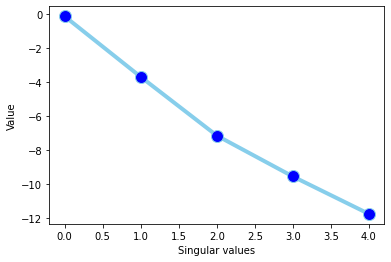

In [35]:
plt.plot(np.arange(0,len(s), dtype=int), np.log(s), marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.xlabel('Singular values')
plt.ylabel('Value')
plt.show()

### Save POD basis in .json file

In [37]:
basis_POD={"rom_settings":{},"nodal_modes":{}}
basis_POD["rom_settings"]["nodal_unknowns"] = ["DISPLACEMENT_X","DISPLACEMENT_Y","DISPLACEMENT_Z"]
basis_POD["rom_settings"]["number_of_rom_dofs"] = np.shape(u)[1]
Dimensions = len(basis_POD["rom_settings"]["nodal_unknowns"])
N_nodes=np.shape(u)[0]/Dimensions
N_nodes = int(N_nodes)
node_Id=np.linspace(1,N_nodes,N_nodes)
i = 0
for j in range (0,N_nodes):
    basis_POD["nodal_modes"][int(node_Id[j])] = (u[i:i+Dimensions].tolist())
    i=i+Dimensions

with open('RomParameters.json', 'w') as f:
    json.dump(basis_POD,f, indent=2)

print('\n\nNodal basis printed in json format\n\n')



Nodal basis printed in json format




## 2. Train Hyper-Reduced Order Model (HROM)

### Define paramenters

In [3]:
with open("ProjectParameters.json",'r') as parameter_file:
    parameters = KratosMultiphysics.Parameters(parameter_file.read())

### Define simulation and model

In [6]:
# Hyper-reduction method : Empirical Cubature
method_HROM = "EmpiricalCubature"
model = KratosMultiphysics.Model()
simulation = StructuralMechanicsAnalysisROM(model,parameters, method_HROM)

### Run simulation

In [7]:
simulation.Run()





Generating matrix of residuals




Generating matrix of residuals




Generating matrix of residuals




Generating matrix of residuals




Generating matrix of residuals




Generating matrix of residuals




Generating matrix of residuals




Generating matrix of residuals




Generating matrix of residuals




Generating matrix of residuals




Generating matrix of residuals




Generating matrix of residuals




Generating matrix of residuals




Generating matrix of residuals




Generating matrix of residuals
iter =  1  nC =  276.65437313262254  dR =  1.0  R =  1
reorthogonalizing
iter =  2  nC =  0.2246769246616922  dR =  19.0  R =  20
reorthogonalizing
iter =  3  nC =  0.0001539299907062079  dR =  19.0  R =  39
reorthogonalizing
iter =  4  nC =  3.247901660572437e-08  dR =  19.0  R =  58
reorthogonalizing
iter =  5  nC =  5.299869212043708e-10  dR =  7.0  R =  65
k = 1, m = 1, error n(res)/n(b) (%) = 69.6216379607422,  Actual error % = 69.6216379607422 
k = 2, m = 2, error 

/home/usuari/Kratos/bin/Release/KratosMultiphysics/RomApplication/empirical_cubature_method.py:108: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha = np.linalg.lstsq(self.G[:, [i]], self.b)[0]


k = 5, m = 5, error n(res)/n(b) (%) = 18.134366587146218,  Actual error % = 18.134366587146218 
k = 6, m = 6, error n(res)/n(b) (%) = 15.974101122810232,  Actual error % = 15.974101122810232 
k = 7, m = 7, error n(res)/n(b) (%) = 14.913033722050859,  Actual error % = 14.913033722050859 
k = 8, m = 8, error n(res)/n(b) (%) = 13.393993992864706,  Actual error % = 13.393993992864706 
k = 9, m = 9, error n(res)/n(b) (%) = 11.856360761415266,  Actual error % = 11.856360761415266 
k = 10, m = 10, error n(res)/n(b) (%) = 9.902557643255973,  Actual error % = 9.902557643255973 
k = 11, m = 11, error n(res)/n(b) (%) = 8.434258033947813,  Actual error % = 8.434258033947813 
k = 12, m = 12, error n(res)/n(b) (%) = 6.608493168790878,  Actual error % = 6.608493168790878 
k = 13, m = 13, error n(res)/n(b) (%) = 4.787878443326727,  Actual error % = 4.787878443326727 
k = 14, m = 14, error n(res)/n(b) (%) = 3.640708105388155,  Actual error % = 3.640708105388155 
k = 15, m = 15, error n(res)/n(b) (%) = 